<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/02_pytorch_classification_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Sentiment Extraction

[Kaggle links](https://www.kaggle.com/competitions/tweet-sentiment-extraction/overview)

## Tech
* NLP Bert
* Extractive Question Answering

In [1]:
"""!pip install shap
!pip install sweetviz"""

#EDA Tool
#import sweetviz as sv
#from ydata_profiling import ProfileReport

#Classic
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as ltb
import matplotlib.pyplot as plt
import seaborn as sns
#import shap
#import lime
#from lime import lime_tabular

#MLops
#import mlflow
#from mlflow.tracking import MlflowClient
#from mlflow.models import infer_signature
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.early_stop import no_progress_loss
#import optuna
#from optuna.samplers import TPESampler
#from autogluon.tabular import TabularDataset, TabularPredictor
#from lazypredict.Supervised import LazyClassifier,LazyRegressor

#Sklearn
from sklearn.model_selection import train_test_split,RepeatedKFold,KFold,StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder, StandardScaler,OneHotEncoder,MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix,mean_squared_error,r2_score,classification_report,ConfusionMatrixDisplay, log_loss,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB

#Deep L
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [2]:
#Import Dataset

from google.colab import files
uploaded = files.upload()


Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [3]:
# Turn data into a DataFrame
df = pd.read_csv(r'train.csv')
Real_test = pd.read_csv(r'test.csv')
df


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


<Axes: >

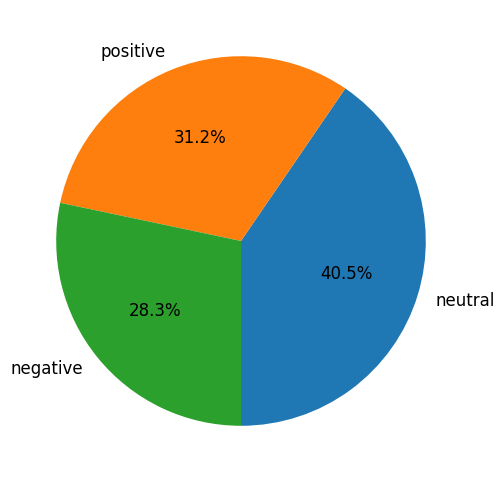

In [4]:
df['sentiment'].value_counts()

fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
df['sentiment'].value_counts().plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

Text(0.5, 0, 'Message Length')

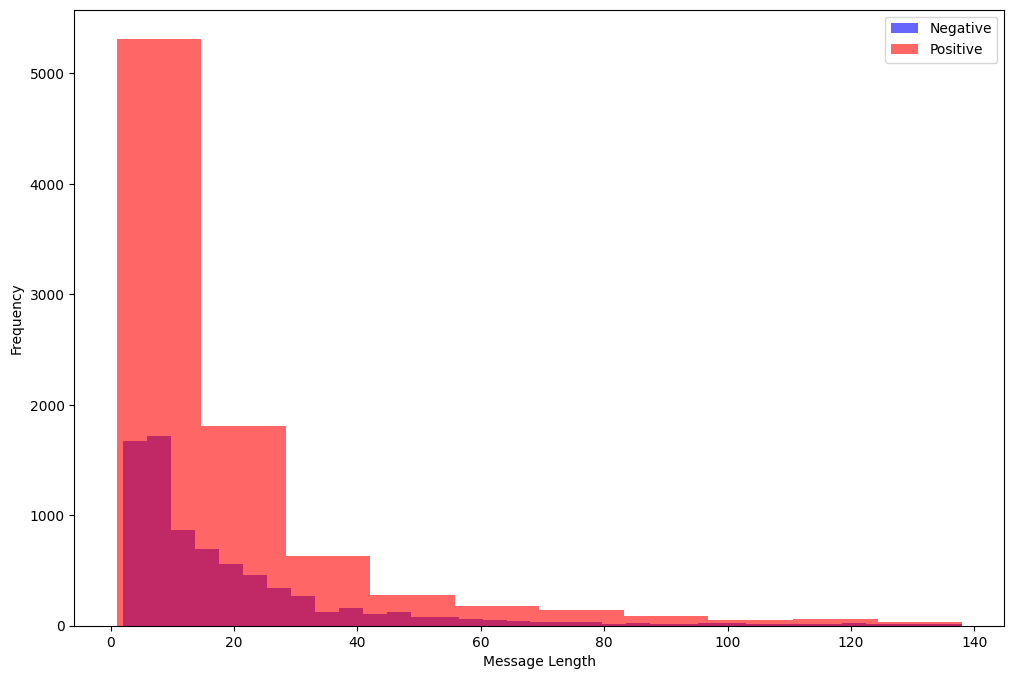

In [5]:

plt.figure(figsize=(12, 8))

df['message_len']=df.selected_text.str.len()
df[df.sentiment=='negative'].message_len.plot(bins=35, kind='hist', color='blue',
                                       label='Negative', alpha=0.6)
df[df.sentiment=='positive'].message_len.plot(kind='hist', color='red',
                                       label='Positive', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")



In [6]:
#Preprocess Data
#df["Sex"] = df["Sex"].map({"M": 0, "F": 1})
df["sentiment"] = df["sentiment"].map({"negative": "-1", "neutral": "0", "positive": "1"})
df['Num_words_text'] = df['text'].apply(lambda x:len(str(x).split()))
df

,textID,text,selected_text,sentiment,message_len,Num_words_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",0,35.0,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,-1,8.0,10
2,088c60f138,my boss is bullying me...,bullying me,-1,11.0,5
3,9642c003ef,what interview! leave me alone,leave me alone,-1,14.0,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",-1,13.0,14
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,-1,6.0,16
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",-1,13.0,23
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,1,25.0,22
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,1,26.0,6


In [7]:
#TEST twitter-roberta-base-sentiment-latest

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)
text = "Covid cases are increasing fast!"
text = preprocess(text)
print(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)


ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Covid cases are increasing fast!
1) negative 0.7236
2) neutral 0.2287
3) positive 0.0477


1. Forward pass
2. Calculate loss/accuracy
3. Optimizer zero grad
4. Loss backwards
5. Optimizer step

  Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer
   

In [8]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
!pip install torchinfo
from torchinfo import summary
from transformers import AutoModelForSequenceClassification, AutoTokenizer

summary(model, input_size=(2, 512), dtypes=['torch.IntTensor'])

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Layer (type:depth-idx)                             Output Shape              Param #
BertModel                                          [2, 768]                  --
├─BertEmbeddings: 1-1                              [2, 512, 768]             --
│    └─Embedding: 2-1                              [2, 512, 768]             23,440,896
│    └─Embedding: 2-2                              [2, 512, 768]             1,536
│    └─Embedding: 2-3                              [1, 512, 768]             393,216
│    └─LayerNorm: 2-4                              [2, 512, 768]             1,536
│    └─Dropout: 2-5                                [2, 512, 768]             --
├─BertEncoder: 1-2                                 [2, 512, 768]             --
│    └─ModuleList: 2-6                             --                        --
│    │    └─BertLayer: 3-1                         [2, 512, 768]             7,087,872
│    │    └─BertLayer: 3-2                         [2, 512, 768]             7,087,872
│ 

In [30]:
import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.autonotebook import tqdm
import torch.nn.functional as F
from torch.optim import lr_scheduler
!pip install utils
import utils

df['text'] = df['text'].apply(lambda x: str(x))
Real_test['text'] = Real_test['text'].apply(lambda x: str(x))
df['uncased_text'] = df['text'].apply(lambda x: x.lower())
Real_test['uncased_text'] = Real_test['text'].apply(lambda x: x.lower())
df['selected_text'] = df['selected_text'].apply(lambda x: str(x).lower())

In [33]:

# Tokenize
df['tokenized_text'] = df['uncased_text'].apply(tokenizer.tokenize)
Real_test['tokenized_text'] = Real_test['uncased_text'].apply(tokenizer.tokenize)
df['tokenized_selected_text'] = df['selected_text'].apply(tokenizer.tokenize)
df


,textID,text,selected_text,sentiment,message_len,Num_words_text,uncased_text,tokenized_text,tokenized_selected_text
0,cb774db0d1,"I`d have responded, if I were going","i`d have responded, if i were going",0,35.0,7,"i`d have responded, if i were going","[i, `, d, have, responded, ,, if, i, were, going]","[i, `, d, have, responded, ,, if, i, were, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,sooo sad,-1,8.0,10,sooo sad i will miss you here in san diego!!!,"[soo, ##o, sad, i, will, miss, you, here, in, ...","[soo, ##o, sad]"
2,088c60f138,my boss is bullying me...,bullying me,-1,11.0,5,my boss is bullying me...,"[my, boss, is, bullying, me, ., ., .]","[bullying, me]"
3,9642c003ef,what interview! leave me alone,leave me alone,-1,14.0,5,what interview! leave me alone,"[what, interview, !, leave, me, alone]","[leave, me, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","sons of ****,",-1,13.0,14,"sons of ****, why couldn`t they put them on t...","[sons, of, *, *, *, *, ,, why, couldn, `, t, t...","[sons, of, *, *, *, *, ,]"
...,...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,-1,6.0,16,wish we could come see u on denver husband l...,"[wish, we, could, come, see, u, on, denver, hu...","[d, lost]"
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",-1,13.0,23,i`ve wondered about rake to. the client has ...,"[i, `, ve, wondered, about, rake, to, ., the, ...","[,, don, `, t, force]"
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,yay good for both of you.,1,25.0,22,yay good for both of you. enjoy the break - y...,"[ya, ##y, good, for, both, of, you, ., enjoy, ...","[ya, ##y, good, for, both, of, you, .]"
27479,ed167662a5,But it was worth it ****.,but it was worth it ****.,1,26.0,6,but it was worth it ****.,"[but, it, was, worth, it, *, *, *, *, .]","[but, it, was, worth, it, *, *, *, *, .]"


In [56]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 5
BERT_PATH = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


MAX_LEN = 128
VALID_BATCH_SIZE = 8
BERT_PATH = "../input/roberta-base/"
MODEL_PATH = "model.bin"
TRAINING_FILE = "../input/train.csv"
TOKENIZER = tokenizers.ByteLevelBPETokenizer(
    vocab_file=f"{BERT_PATH}/vocab.json",
    merges_file=f"{BERT_PATH}/merges.txt",
    lowercase=True,
    add_prefix_space=True
)


In [50]:
class TweetReviewDataset(Dataset):
    def __init__(self,review,tokenizer,targets,max_len):
        self.review = review
        self.tokenizer = tokenizer
        self.targets = targets
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    def __getitem__(self,index):
        review = str(self.review[index])
        target = self.targets[index]

        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
        )

        return {'review_text':review,'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [52]:
df_train , df_val = train_test_split(df,test_size = 0.2,random_state = 42)

In [53]:
def create_data_loader(df, tokenizer, max_len, batch_size):

    ds = TweetReviewDataset(
    review=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )

In [57]:
train_len = len(df_train)
val_len = len(df_val)

train_loader = create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
val_loader = create_data_loader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)

In [58]:
class SentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super(SentimentClassifier,self).__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.bert.config.hidden_size,n_classes)

    def forward(self,input_ids,attention_mask):
        _,pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

        output = self.drop(pooled_output)
        return self.out(output)

In [62]:
model = SentimentClassifier(3)

optimizer = transformers.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [63]:
def train_epoch(model,data_loader,loss_fn,optimizer,scheduler,n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for i,d in tqdm(enumerate(data_loader)):

        input_ids = d['input_ids']
        attention_mask = d['attention_mask']
        targets = d["targets"]

        outputs = model(input_ids = input_ids,attention_mask = attention_mask)

        _,preds = torch.max(outputs,dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())


        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)



In [64]:
def eval_model(model, data_loader,loss_fn, n_examples):

    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():

        for i,d in tqdm(enumerate(data_loader)):

            input_ids = d["input_ids"]
            attention_mask = d["attention_mask"]
            targets = d["targets"]

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [66]:
for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
    model,
    train_loader,
    loss_fn,
    optimizer,
    scheduler,
    train_len
  )

    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
    model,
    val_loader,
    loss_fn,
    val_len
  )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

Epoch 1/5
----------


0it [00:00, ?it/s]

TypeError: new(): invalid data type 'str'

In [60]:

# freeze all the parameters
for param in model.parameters():
    param.requires_grad = False

In [12]:
# Set the manual seeds
torch.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(selected_text)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True))

NameError: name 'selected_text' is not defined